## Init

In [20]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matrixensembles import GOEsampler, MatrixStats, Betasampler, LatticeSampler, PalHuseSelector, OganesyanHuseSampler, CrossoverSampler, BosonChainSampler, BosonOHSampler
from studies import ManyBodyLevels, CrossDiagonal, RandomCrossDiagonal
from utils import poissonweights, errorhist, paramstring
base_dir = Path('../out/manybody/')

# set default plot size to 720p
# plt.rcParams['figure.figsize'] = [1280/96, 720/96]
plt.rcParams['pgf.texsystem'] = 'lualatex'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Localization crossover

### System of spins

In [34]:
matrixstats = MatrixStats(OganesyanHuseSampler(n, W))
matrixstats.collect(n_realizations=20)
r = matrixstats.d2correlations()
print(r)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:06<00:00,  3.13it/s]

[[0.33265545 0.6595656  0.40698743 ... 0.0599407  0.20796576 0.09722828]
 [0.32543208 0.03579492 0.12629211 ... 0.13151034 0.13839112 0.0622371 ]
 [0.56567891 0.14979426 0.22015528 ... 0.06910119 0.09298732 0.04565498]
 ...
 [0.29886936 0.53039645 0.26985083 ... 0.0779622  0.21195705 0.09915918]
 [0.81379136 0.81698854 0.15504118 ... 0.05137654 0.0545379  0.02684625]
 [0.07597937 0.14066458 0.8297414  ... 0.08476572 0.04912594 0.0214592 ]]


In [36]:
d, n, w0 = 1, 16, 0
W, t = 3, 1
TYPE='spins'
study = ManyBodyLevels(n_excitations=None)

def correlation_transition(corr_W, n):
	corr_r, corr_err = np.zeros_like(corr_W, dtype=np.float64), np.zeros_like(corr_W, dtype=np.float64)
	for i, W in enumerate(corr_W):
		matrixstats = MatrixStats(OganesyanHuseSampler(n, W))
		matrixstats.collect(n_realizations=50)
		r = matrixstats.d2correlations()
		r_avg = np.mean(r, axis=1) # average over disorder and states
		corr_r[i] = np.mean(r_avg)
		corr_err[i] = np.std(r_avg) / np.sqrt(len(r_avg))
	return corr_W, corr_r, corr_err

correlation_results = {}
for i, L in enumerate([8, 10, 12, 14, 16]):
	corr_W = np.arange(2, 11)
	corr_W, corr_r, corr_err = correlation_transition(corr_W, L)
	correlation_results[L] = (corr_W, corr_r, corr_err)

100%|██████████| 50/50 [20:54<00:00, 25.09s/it]


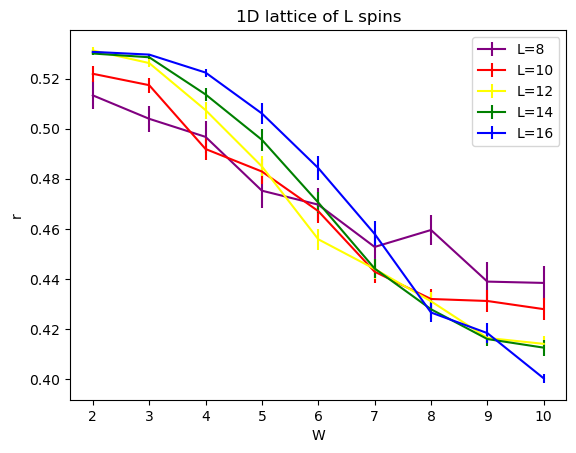

In [45]:
c = iter(["purple", "red", "yellow", "green", "blue"])
# restore default plot size

for L, (corr_W, corr_r, corr_err) in correlation_results.items():
	plt.errorbar(corr_W, corr_r, yerr=corr_err, label=f'L={L}', fmt='-', color=next(c))
plt.xlabel("W")
plt.ylabel("r")
plt.title("1D lattice of L spins")
plt.legend()
odir = output_dir / "spins"
odir.mkdir(parents=True, exist_ok=True)
plt.savefig(odir / f"correlation_transition.png", dpi=300)
plt.savefig(odir / f"correlation_transition.pdf")

### System of oscillators

#### Statistics

In [16]:
d, n, w0 = 1, 10, 100
t, W, K = 1, 2, 1
TYPE = 'oscillators'
matrixstats = MatrixStats(BosonChainSampler(n, W, t, e=1, w0=w0, K=K))
# matrixstats = MatrixStats(LatticeSampler(d, n, W, t, w0))
# matrixstats = MatrixStats(CrossoverSampler(n, W, t))
matrixstats.collect(n_realizations=500, eigenvectors=True)
print(f"r = {np.mean(matrixstats.d2correlations())}")

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 365.73it/s]

r = 0.4929813696696882


In [17]:
K = 0.01
# study = CrossDiagonal(n_excitations=5, K=K)
study = ManyBodyLevels(2, K)
manybody = study(matrixstats)
print(f"r = {np.mean(manybody.d2correlations())}")

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:00<00:00, 257.41it/s]

r = 0.42481797837017926


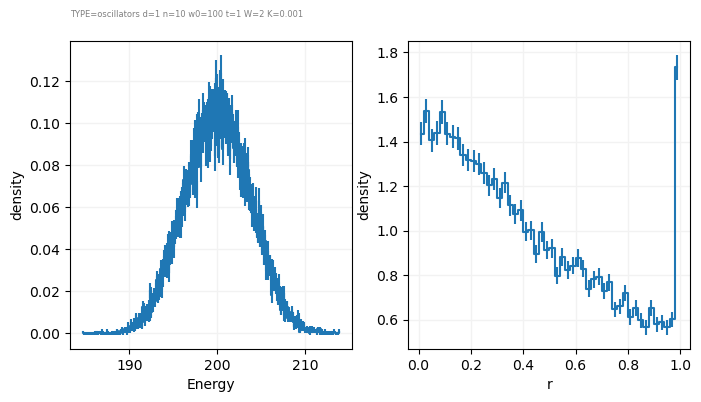

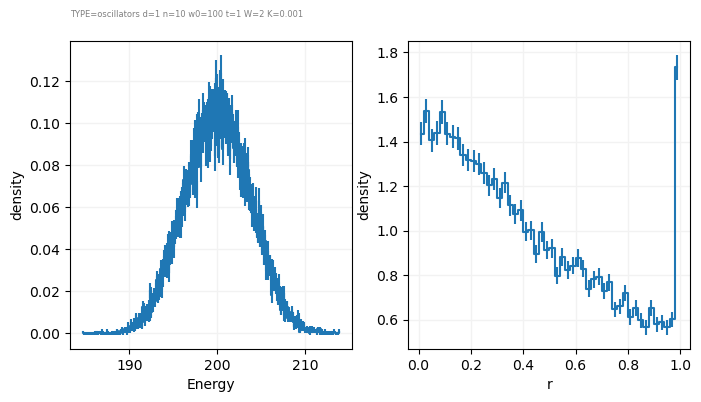

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
params = dict(TYPE=TYPE, d=d, n=n, w0=w0, t=t, W=W, K=K)
errorhist(ax[0], manybody.eigenvalues().flatten(), bins=500)
ax[0].set_xlabel("Energy")
ax[0].text(0, 1.1, paramstring(params, 'plot'), fontsize=6, color='gray', transform=ax[0].transAxes, verticalalignment='top')
errorhist(ax[1], manybody.d2correlations().flatten(), bins=50)
ax[1].set_xlabel("r")
ax[0].lines[-1].set_label('K=0.1')
fig

In [71]:
odir = base_dir / "oscillators"
odir.mkdir(parents=True, exist_ok=True)
name = "random_crossdiagonal_K0_01_05"
fig.savefig(odir / f'{name}_{paramstring(params, "file")}.png')
fig.savefig(odir / f'{name}_{paramstring(params, "file")}.pdf')
print(f"r={np.mean(manybody.d2correlations().flatten())}")

r=0.38663558491675004


#### Transition

In [22]:
d, n, w0 = 1, 14, 100
W, t, K = 3, 1, 0.1
TYPE='oscillators'
study = ManyBodyLevels(n_excitations=None, K=K)

def correlation_transition(corr_W, n):
	corr_r, corr_err = np.zeros_like(corr_W, dtype=np.float64), np.zeros_like(corr_W, dtype=np.float64)
	for i, W in enumerate(corr_W):
		# singlestats = MatrixStats(LatticeSampler(d, n, W, t, w0))
		# matrixstats = MatrixStats(BosonChainSampler(n, W, t))
		matrixstats = MatrixStats(BosonOHSampler(n, W))
		matrixstats.collect(n_realizations=10)
		# singlestats.collect(n_realizations=10)
		# matrixstats = study(singlestats)
		r = matrixstats.d2correlations()
		r_avg = np.mean(r, axis=1) # average over disorder and states
		corr_r[i] = np.mean(r_avg)
		corr_err[i] = np.std(r_avg) / np.sqrt(r_avg.size)
	return corr_W, corr_r, corr_err

correlation_results = {}
for i, L in enumerate([10]):
	corr_W = np.arange(2, 11)
	corr_W, corr_r, corr_err = correlation_transition(corr_W, L)
	correlation_results[L] = (corr_W, corr_r, corr_err)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


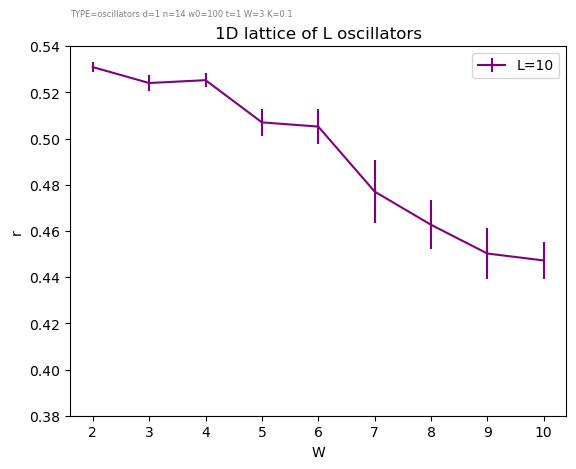

In [24]:
c = iter(["purple", "red", "yellow", "green", "blue"])
# restore default plot size

for L, (corr_W, corr_r, corr_err) in correlation_results.items():
	plt.errorbar(corr_W, corr_r, yerr=corr_err, label=f'L={L}', fmt='-', color=next(c))
plt.xlabel("W")
plt.ylabel("r")
plt.title("1D lattice of L oscillators")
plt.ylim(0.38, 0.54)
plt.legend()
params = dict(TYPE=TYPE, d=d, n=n, w0=w0, t=t, W=W, K=K)
plt.text(0, 1.1, paramstring(params, 'plot'), fontsize=6, color='gray', transform=plt.gca().transAxes, verticalalignment='top')
odir = base_dir / "oscillators"
odir.mkdir(parents=True, exist_ok=True)
plt.savefig(odir / f"lattice_correlation_transition.png", dpi=300)
plt.savefig(odir / f"lattice_correlation_transition.pdf")

## Additional studies

### Conservation of crystal momentum at small disorder

In [10]:
d, n, w0 = 1, 8, 100
W, t = 0.2, 1
K = 0
TYPE='spins'
matrixstats = MatrixStats(OganesyanHuseSampler(n, W))
matrixstats.collect(10**6)

100%|██████████| 14285/14285 [04:47<00:00, 49.72it/s]


r=0.26970066387634634


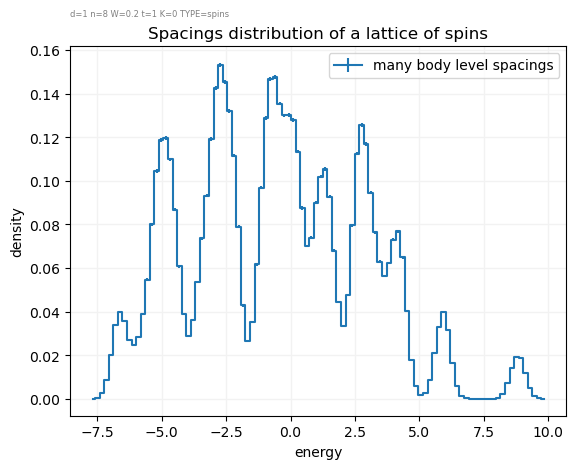

In [16]:
heights, borders = np.histogram(matrixstats.eigenvalues().flatten(), bins=100)
norm = np.sum(heights) * np.diff(borders)[0]
heights = heights / norm
weights = poissonweights(heights, norm=norm)
centers = borders[:-1] + np.diff(borders) / 2

plt.xlabel("energy")
plt.ylabel("density")

plt.errorbar(
    centers,
    heights,
    yerr = 1/weights,
    marker = '.',
    markersize = 0,
    drawstyle = 'steps-mid',
    label = "many body level spacings"
)

# add a grid of very light gray color
plt.grid(color='0.95', linestyle='-', linewidth=1)
plt.legend()
plt.title(f"Spacings distribution of a lattice of {TYPE}")
params = dict(d=d, n=n, W=W, t=t, K=K, TYPE=TYPE)
plt.text(0, 1.1, paramstring(params, 'plot'), fontsize=6, color='gray', transform=plt.gca().transAxes, verticalalignment='top')

plt.savefig(output_dir / f'spins/spins_{paramstring(params, "file")}.png')
plt.savefig(output_dir / f'spins/spins_{paramstring(params, "file")}.pdf')
print(f"r={np.mean(matrixstats.d2correlations().flatten())}")
plt.show()